# Fake News Detection by Stance Prediction

The task is to detect fake news by **predicting the stance** associated to every news article in the __[FNC Dataset](https://github.com/FakeNewsChallenge/fnc-1)__.


## Data Input & Preprocessing

Read csv files into Pandas DataFrames and merge them on `Body ID`


In [19]:
import pandas as pd

merged = [None] * 2
for idx, prefix in enumerate(['train', 'test']):
    body_df = pd.read_csv(f'{prefix}_bodies.csv', index_col=0)
    stance_df = pd.read_csv(f'{prefix}_stances.csv')

    merged_df = pd.merge(stance_df, body_df, on='Body ID')
    merged_df = merged_df.rename(
        columns={'Headline': 'headline', 'Body ID': 'body_id',
                     'Stance': 'stance', 'articleBody': 'body'}
    )
    merged[idx] = merged_df

train_df, test_df = merged

In [20]:
import random

len_train = len(train_df)
sample_indices = random.sample(range(len_train), k=int(0.2*len_train))

val_df = train_df.iloc[sample_indices]
train_df = train_df.drop(sample_indices)

### Data Exploration

The training dataset consists of 39978 headline and article pairs.
The validation dataset consists of 9994 headline and article pairs.
The test dataset consists of 25413 headline and article pairs.


                                                headline  body_id     stance
8101   Comcast gets customer fired for complaining ab...     2149  unrelated
26647  Amazon.com to open first physical store in Man...      267  unrelated
3884   Judd Nelson rebuffs Internet rumors that he di...       26  unrelated
18556  Banksy's illustrated response to the Charlie H...      730  unrelated
13824  Alleged Ottawa gunman: What we know so far abo...      186  unrelated
33068  ISIS Video Purports To Show Beheading Of Briti...     1757    discuss
37002  Seven girls fall pregnant after five day schoo...     2044  unrelated
3126   Elderly Woman Arrested for Kidnapping Neighbor...      816  unrelated
38464  The Internet Tried To Make Axl Rose Its Latest...     1645  unrelated
4766   James Foley, Missing Am

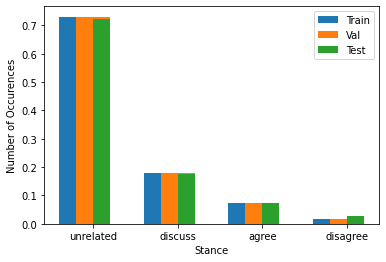

In [21]:
import matplotlib.pyplot as plt

dfs = [train_df, val_df, test_df]
labels = ['training', 'validation', 'test']
df_zip = zip(dfs, labels)
for df, label in df_zip:
    print(f'The {label} dataset consists of {len(df)} headline and article pairs.')

print('\n')

# dropping body text to not clog up output. N.B. drop is not inplace by default
print(train_df.drop(columns=['body']).sample(10))   
print('\n')

train_counts = train_df['stance'].value_counts(normalize=True)
test_counts = test_df['stance'].value_counts(normalize=True)

val_counts = val_df['stance'].value_counts(normalize=True)

plt.figure()
plt.bar(train_counts.index,train_counts.values, width=-0.4, align='edge', label='Train')
plt.bar(val_counts.index,train_counts.values, width=0.4, align='center', label='Val')
plt.bar(test_counts.index,test_counts.values, width=0.2, align='edge', label='Test')
plt.legend()
plt.xlabel('Stance')
plt.ylabel('Number of Occurences')

plt.show()


## Feature Extraction

### TF/IDF

Uses the `scikit-learn` module's implementation of TF/IDF. Built on both the headlines and bodies in the train dataset, and fit to both the train and test dataset.


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

vectorizer = TfidfVectorizer(decode_error='ignore', lowercase=True, min_df=2)

raw = {label: np.concatenate((df['body'].drop_duplicates().values,
                              df['headline'].drop_duplicates().values))
                              for df, label in zip(dfs, labels)}



tf_idf = {key: vectorizer.fit_transform(value.astype('U'))
            for key, value in raw.items()}


for key, value in tf_idf.items():
    print(f'{key} feature size: {value.shape}')

training feature size: (3294, 14106)
validation feature size: (3009, 13213)
test feature size: (1794, 10453)


#### Sampling ten random features from the TF/IDF dictionary

In [23]:
print(random.sample(vectorizer.get_feature_names(), 10))

['predicts', 'thieves', 'company', 'lost', 'musician', 'made', 'sunglasses', 'quickly', 'expose', 'colony']


### BERT Transformer

In [24]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
LEN_MAX_INPUT = tokenizer.max_model_input_sizes['bert-base-uncased']

In [25]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:LEN_MAX_INPUT-2]
    return tokens

#### Create a dataset

Get item returns BERT tokenized IDs and their stance

In [137]:
import torch
from torch.utils import data

class DataFrameDataset(data.Dataset):

    def __init__(self, df, stance_mapping):
        self.df = df
        self.map = stance_mapping


    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        items = self.df.iloc[idx]
        headline = self._get_token_ids(items['headline'])
        body = self._get_token_ids(items['body'])
        stance = torch.tensor(self.map[items['stance']])
        return torch.stack([headline, body]), stance

    def _get_token_ids(self, text):
        tokens = tokenize_and_cut(text)
        ids = tokenizer.convert_tokens_to_ids(tokens)
        ids = [tokenizer.cls_token_id] + ids + [tokenizer.sep_token_id]
        ids.extend([0 for _ in range(512 - len(ids))])
        return torch.tensor(ids)


## Related / Unrelated Classification

### Simple ML Method

#### Logistic Regression

Statsmodels Logistic Regression, trained on the whole training dataset

In [ ]:
stance_mapping = {
    'unrelated': 0,
    'discuss': 1,
    'agree': 2,
    'disagree': 3
}
datasets = [DataFrameDataset(df, stance_mapping) for df in dfs]

dataloaders = []

### Deep Learning Method


In [ ]:
stance_mapping = {
    'unrelated': 0,
    'discuss': 1,
    'agree': 2,
    'disagree': 3
}
datasets = [DataFrameDataset(df, stance_mapping) for df in dfs]

train_loader, _, test_loader = [data.DataLoader(d, shuffle=True, batch_size=len(d))
                                                for d in datasets]

In [ ]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

train_iter, val_iter, test_iter = [iter(cycle(x)) for x in dataloaders]